In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import eazy

#eazy.symlink_eazy_inputs()

eazy.symlink_eazy_inputs(path=os.path.dirname(eazy.__file__)+'/data', path_is_env=False)

field = 'goodss'



/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/templates -> ./templates
/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

In [4]:
params = {}
params['CATALOG_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_temp.v4.3.cat'%field

params['MAIN_OUTPUT_FILE'] = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_v4.4'%field

# Galactic extinction
params['MW_EBV'] = 0.0103

params['Z_STEP'] = 0.01
params['Z_MIN'] = 0.01
params['Z_MAX'] = 12.

params['PRIOR_ABZP'] = 25 
params['PRIOR_FILTER'] = 205 # HST H-band
params['PRIOR_FILE'] = 'templates/prior_F160W_TAO.dat'

params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'

params['FIX_ZSPEC'] = False

In [5]:
translate_file = '/Users/rsimons/Desktop/clear/Catalogs/%s_3dhst_temp.v4.1.translate'%field
self = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, zeropoint_file=None, 
                          params=params, load_prior=True, load_products=False)

Read default param file: /anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /Users/rsimons/Desktop/clear/Catalogs/goodss_3dhst_temp.v4.3.cat
f_F160W e_F160W (205): hst/wfc3/IR/f160w.dat
f_U e_U (103): ESO/vimos_u.res
f_F435W e_F435W (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_F606Wcand e_F606Wcand (236): hst/ACS_update_sep07/wfc_f606w_t81.dat
f_F606W e_F606W (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_F775W e_F775W (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_F814Wcand e_F814Wcand (239): hst/ACS_update_sep07/wfc_f814w_t81.dat
f_F850LP e_F850LP (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F850LPcand e_F850LPcand (240): hst/ACS_update_sep07/wfc_f850lp_t81.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_J e_J ( 34): ESO/isaac_j.res
f_F140W e_F140W (204): hst/wfc3/IR/f140w.dat
f_H e_H ( 36): ESO/isaac_h.res
f_Ks e_Ks ( 37): ESO/isaac_ks.res
f_IRAC1 e_IRAC1 ( 18): IRAC/irac_tr1_2004-08-09.dat
f

Iteration:  0
17505
Compute best fits
Fit 112.7 s (n_proc=8, NOBJ=17505)
Iteration:  1
17505
Compute best fits
Fit 121.9 s (n_proc=8, NOBJ=17505)
`error_residuals`: force uncertainties to match residuals
Iteration:  2
15284
Compute best fits
Fit 117.4 s (n_proc=8, NOBJ=15284)
`error_residuals`: force uncertainties to match residuals


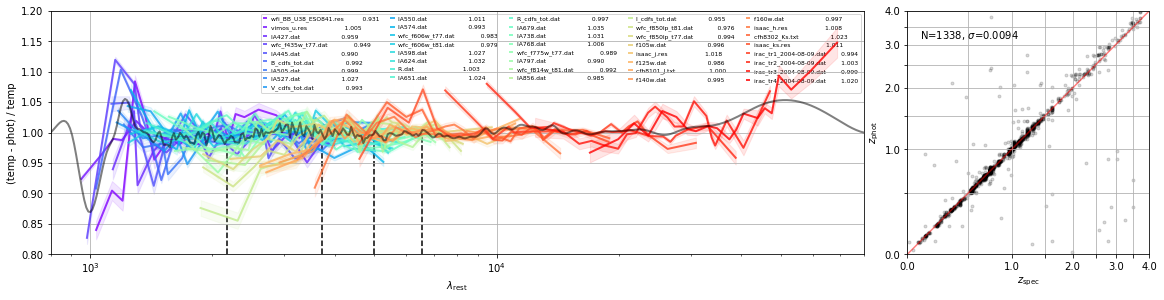

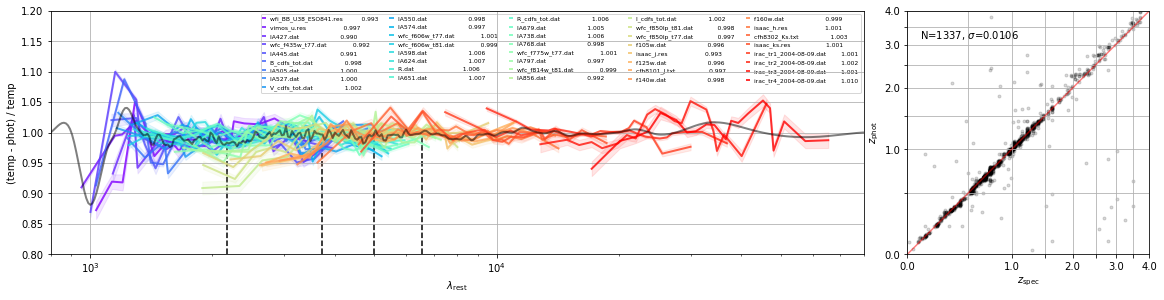

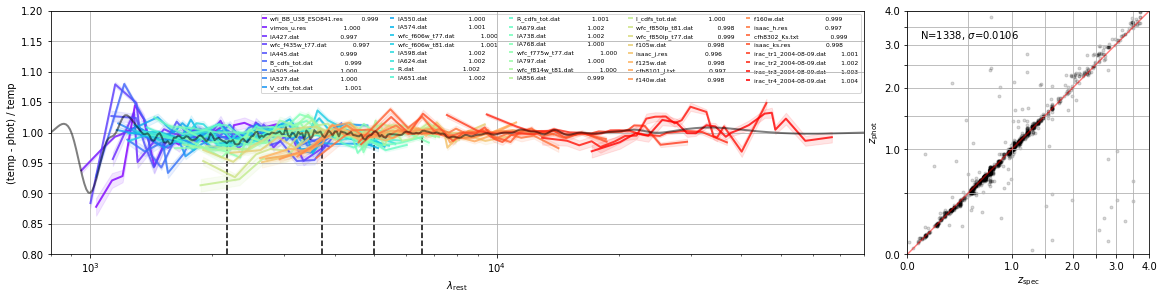

In [6]:
NITER = 3
NBIN = np.minimum(self.NOBJ//100, 180)

self.param.params['VERBOSITY'] = 1.
for iter in range(NITER):
    print('Iteration: ', iter)
    sn = self.fnu/self.efnu
    clip = (sn > 10).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    print(len(np.where(clip == True)[0]))
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False, 
                              update_zeropoints=True, iter=iter, n_proc=8, 
                              save_templates=False, error_residuals=(iter > 0), 
                              NBIN=NBIN, get_spatial_offset=False)

In [7]:
# Turn off error corrections derived above
self.efnu = self.efnu_orig*1

# Full catalog
sample = np.isfinite(self.cat['z_spec'])
self.fit_parallel(self.idx[sample], n_proc=8)

Compute best fits
Fit 316.0 s (n_proc=8, NOBJ=50507)


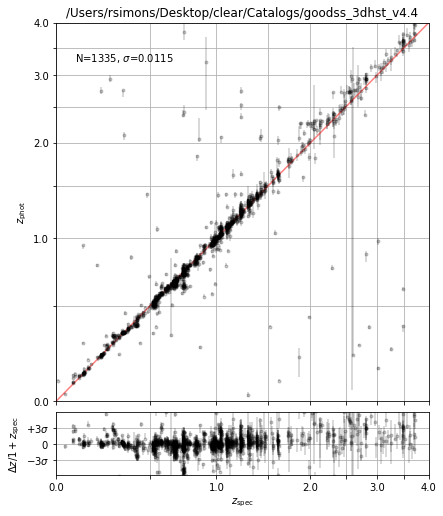

In [8]:
# Show zspec-zphot comparison
fig = self.zphot_zspec()

In [9]:
zout, hdu = self.standard_output(rf_pad_width=0.5, rf_max_err=2, prior=True, beta_prior=True)

Get best fit coeffs & best redshifts
Get parameters (UBVJ=[153, 154, 155, 161], LIR=[8, 1000])
Rest-frame filters: [153, 154, 155, 161]


/anaconda2/envs/grizli/lib/python3.5/site-packages/eazy/photoz.py:2280: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeffs_draw[:, ok_temp] = np.random.multivariate_normal(coeffs_i[ok_temp], covar, size=get_err)


Rest-frame filters: [270, 274, 120, 121, 156, 157, 158, 159, 160, 161, 162, 163]


In [10]:
hdu.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ID            1 ImageHDU         7   (50507,)   uint32   
  2  ZBEST         1 ImageHDU         7   (50507,)   float32   
  3  ZGRID         1 ImageHDU         7   (256,)   float32   
  4  CHI2          1 ImageHDU         9   (256, 50507)   float32   
  5  COEFFS        1 ImageHDU        22   (12, 50507)   float64   
  6  TEMPL         1 ImageHDU         7   (5994,)   float64   
  7  TEMPF         1 ImageHDU         8   (5994, 12)   float64   
  8  REST_UBVJ     1 ImageHDU        14   (5, 4, 50507)   float32   


In [11]:
self.write_zeropoint_file(file = '%s_v4.4.zeropoint'%field)

In [12]:
m = self.filters

In [13]:
for mm in m:
    print (mm.name.split(' ')[0].split('/')[-1])

f160w.dat
vimos_u.res
wfc_f435w_t77.dat
wfc_f606w_t81.dat
wfc_f606w_t77.dat
R.dat
wfc_f775w_t77.dat
wfc_f814w_t81.dat
wfc_f850lp_t77.dat
wfc_f850lp_t81.dat
f125w.dat
isaac_j.res
f140w.dat
isaac_h.res
isaac_ks.res
irac_tr1_2004-08-09.dat
irac_tr2_2004-08-09.dat
irac_tr3_2004-08-09.dat
irac_tr4_2004-08-09.dat
wfi_BB_U38_ESO841.res
B_cdfs_tot.dat
V_cdfs_tot.dat
R_cdfs_tot.dat
I_cdfs_tot.dat
IA427.dat
IA445.dat
IA505.dat
IA527.dat
IA550.dat
IA574.dat
IA598.dat
IA624.dat
IA651.dat
IA679.dat
IA738.dat
IA768.dat
IA797.dat
IA856.dat
cfh8101_J.txt
cfh8302_Ks.txt
f105w.dat


In [16]:
self.

41

In [42]:
print(self.filters[0].name.split(' ')[0])

hst/wfc3/IR/f160w.dat


In [51]:
zout.info()

<GTable length=38279>
     name       dtype        unit       format n_bad
-------------- ------- ---------------- ------ -----
            id   int64                             0
            ra float64                             0
           dec float64                             0
        z_spec float64                             0
      nusefilt   int64                             0
        lc_min float64                     .1f     0
        lc_max float64                     .1f     0
      numpeaks   int64                             0
        z_phot float64                             0
   z_phot_chi2 float64                             0
   z_phot_risk float64                             0
    z_min_risk float64                             0
      min_risk float64                             0
z_chi2_noprior float64                             0
  chi2_noprior float64                    8.4f     0
          z025 float64                    8.4f     0
          z160 float64  